## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [ ]:
# Import packages
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


# Load in data
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [ ]:
# Load pre-saved tokens from a pickle file
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

# Count token frequencies
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

# Create a DataFrame of token frequencies
gdf = pd.DataFrame(token_freq, columns=['token', 'count'])

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


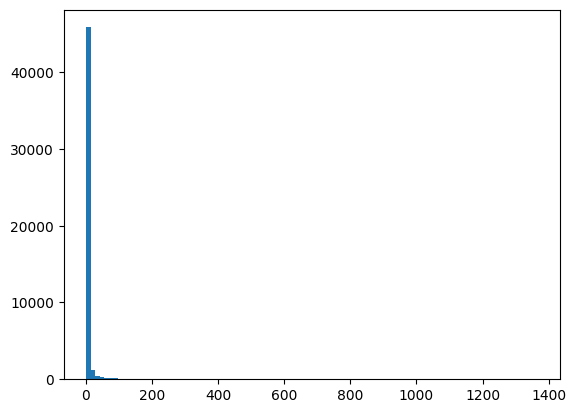

In [ ]:
# Plot histogram of token frequencies
gdf['count'].hist(grid=False, bins=100)

# Summary of descriptive statistics for the count column in the gdf DataFrame
# Column contains the frequencies of the tokens.
gdf['count'].describe()

In [ ]:
# 48,691 unique tokens in the dataset
# Mean frequency is 5.69, but the median (50th percentile) is only 1
# (most tokens occur very infrequently, with a few tokens occurring very frequently)
# The least frequent tokens occur only once
# The most frequent token occurs 1,365 times
# A relatively high standard deviation of 27.72 compared to the mean indicates that the distribution is highly spread out

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [ ]:
# Load data from Parquet file into pandas DataFrame
df = pd.read_parquet('Phishing_clean.parquet')

# Separate the target variable (Email Type) from the features (all other columns)
y = df['Email Type']
X = df.drop('Email Type', axis=1)

In [ ]:
# 1
# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

# 2
# Train a linear regression model
lm_0 = LinearRegression(fit_intercept=False).fit(X_train, y_train)

# Predict
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)

# Evaluate the model's performance using R-squared
print('train: ', r2_score(y_hat_train_0, y_train))  # R-squared for training set
print('test: ', r2_score(y_hat_test_0, y_test))    # R-squared for test set


train:  0.6210107280960204
test:  -0.00026838432670373


In [ ]:
# 3
# Create df to store the feature names and corresponding coefficients from the trained model
rdf = pd.DataFrame({'variable': lm_0.feature_names_in_, 'value': lm_0.coef_})

# Add new column for absolute value of coefficients
rdf['abs'] = np.abs(rdf['value'])

# Sort the df by the absolute value of the coefficients
rdf.sort_values('abs', ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


In [ ]:
# Top variables are just numbers

# Model does well on the training set with an R2 score of 0.62,
# but on test set, it barely performs better than guessing the average.
# (Likely means the model is overfitting.)

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

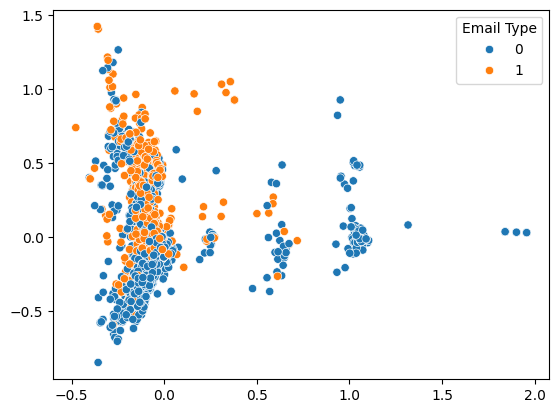

In [ ]:
# Perform PCA to reduce data to 2 components
reduction = PCA(n_components=2).fit(X_train)

# Transform the training and test data using the fitted PCA model
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

# Create scatter plot of the transformed test data
sns.scatterplot(x=Z_test[:, 0], y=Z_test[:, 1], hue=y_test)

In [ ]:
# Orange dots (#1) = scams
# They tend to have a high second component and low first component

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [ ]:
# Perform PCA to reduce data to 2610 components
reduction = PCA(n_components=2610).fit(X_train)

# Transform training and test data
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

# Train a linear regression model on the reduced training data
lm_k = LinearRegression().fit(Z_train, y_train)

# Predict the target variable using the model on both training and test sets
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

# Evaluate model's performance using R-squared
print('Train r2: ', r2_score(y_hat_train, y_train))
print('Test r2: ', r2_score(y_hat_test, y_test))

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


In [ ]:
# Much better performance than first regression model
# 0.587 > -0.00026 and 0.692 ~ = 0.621

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components in high-dimensional regression helps simplify the data by turning it into fewer variables that aren't correlated. This can make the model more stable and prevent issues like overfitting or running too slowly when you have a lot of predictors. The downside is that these new variables (principal components) might be harder to understand in terms of the original data.